In [1]:
import kbench
from xaosim.shmlib import shm
import numpy as np
import matplotlib.pyplot as plt
from time import sleep

chip = kbench.Chip(6)

✅ BMC lib found. Running in control mode.


/tmp/ipykernel_85648/3895357141.py:7: DeprecationWarning: Chip is deprecated, use Arch instead
  chip = kbench.Chip(6)


In [2]:
channel = 17
current = 300 # mA
tension = 10 # V

CUR = current * 65535 / 300
VOLT = tension * 65535 / 40

In [3]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:CUR:{int(CUR)}")

'CH:17-17:CUR:65535\t>> Channel 17-17 set to 65535'

In [4]:
kbench.xpow.send_command(f"CH:{channel}-{channel}:VOLT:{int(VOLT)}")

'CH:17-17:VOLT:16383\t>> Channel 17-17 set to 16383'

In [5]:
kbench.xpow.send_command(f"CH:{channel}:VAL?")

'CH:17:VAL?\t>> Channel 17 = 9.986V, 13.743mA'

In [6]:
# px window around the output
crop_size = 10
# px coordinates of the output spots
crop_centers = np.array([(320, 310),
                        (353, 310),
                        (385, 310),
                        (417, 310)])

# Power ramp
ramp = np.linspace(0, 1.2, 101) # [W]

# Controlled equipments
shifter = kbench.PhaseShifter(17)
cam = kbench.Cred3()
arch = kbench.Arch(6)

Cred3 camera initialized with dark subtraction


[ 0.     6.843  9.647 11.792 13.605 15.2   16.601 17.894 19.13  20.257
 21.357 22.373 23.335 24.27  25.149 26.029 26.881 27.678 28.475 29.218
 29.988 30.702 31.444 32.104 32.846 33.478 34.165 34.797 35.484 36.117
 36.722] [ 0.     4.945  6.992  8.563  9.891 11.057 12.111 13.082 13.987 14.835
 15.638 16.4   17.13  17.828 18.502 19.151 19.777 20.39  20.98  21.555
 22.113 22.663 23.196 23.717 24.226 24.725 25.217 25.696 26.166 26.631
 27.087] [0.         0.03370512 0.06727266 0.10099848 0.13455345 0.16777198
 0.20142708 0.23446044 0.26755218 0.30047208 0.33352157 0.36649675
 0.39972855 0.4327341  0.46480724 0.49801631 0.53117212 0.5643821
 0.59683904 0.62979399 0.66321461 0.69579943 0.72928069 0.76189027
 0.79504887 0.82777703 0.86147047 0.89482838 0.92780332 0.96111279
 0.99454193]


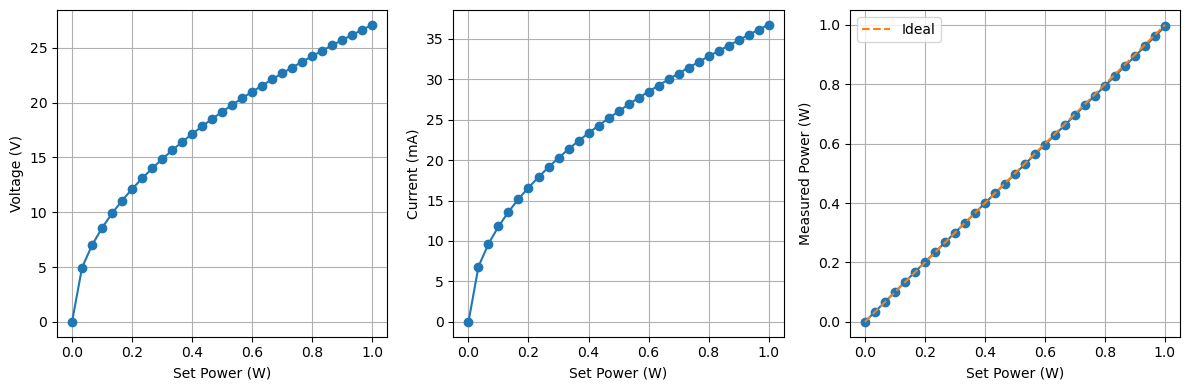

In [7]:
# Test the new set_power() method with auto-calibration
shifter = kbench.PhaseShifter(17)

power_range = np.linspace(0, 1, 31)

real_voltage = np.empty_like(power_range)
real_current = np.empty_like(power_range)
real_power = np.empty_like(power_range)

for i, p in enumerate(power_range):
    shifter.set_power(p)
    real_voltage[i] = shifter.get_voltage()
    real_current[i] = shifter.get_current()
    real_power[i] = shifter.get_power()

print(real_current, real_voltage, real_power)

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].plot(power_range, real_voltage, '-o')
axs[0].set_ylabel("Voltage (V)")
axs[0].set_xlabel("Set Power (W)")
axs[0].grid()

axs[1].plot(power_range, real_current, '-o')
axs[1].set_ylabel("Current (mA)")
axs[1].set_xlabel("Set Power (W)")
axs[1].grid()

axs[2].plot(power_range, real_power, '-o')
axs[2].plot(power_range, power_range, '--', label='Ideal')
axs[2].set_ylabel("Measured Power (W)")
axs[2].set_xlabel("Set Power (W)")
axs[2].legend()
axs[2].grid()
plt.tight_layout()
plt.show()


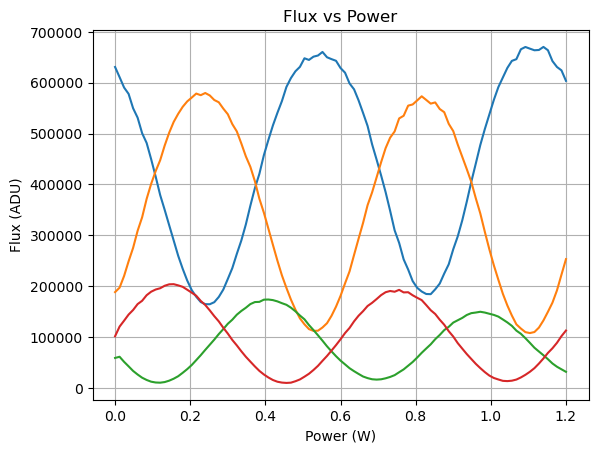

In [8]:
# Data acquisition
flux = []
for power in ramp:
    shifter.set_power(power)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Power (W)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Power")
plt.grid()
plt.show()

sleep(3)
shifter.turn_off()

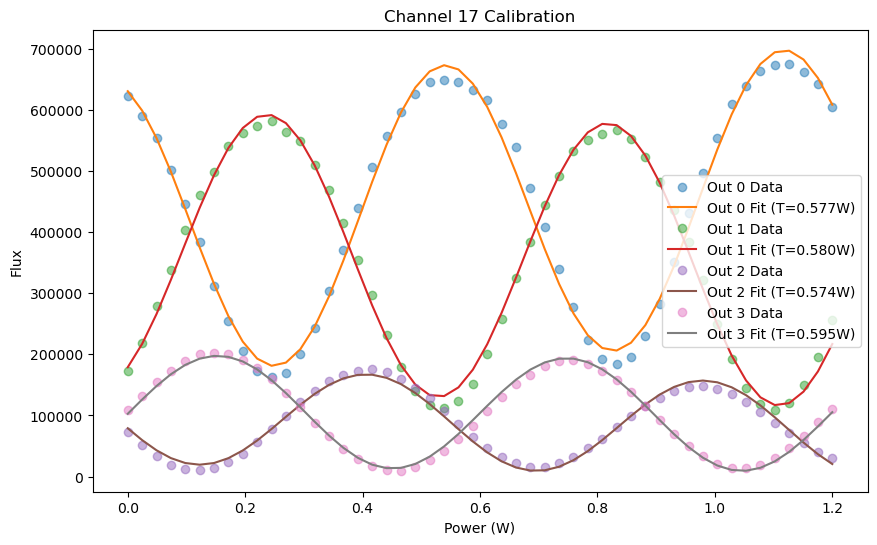

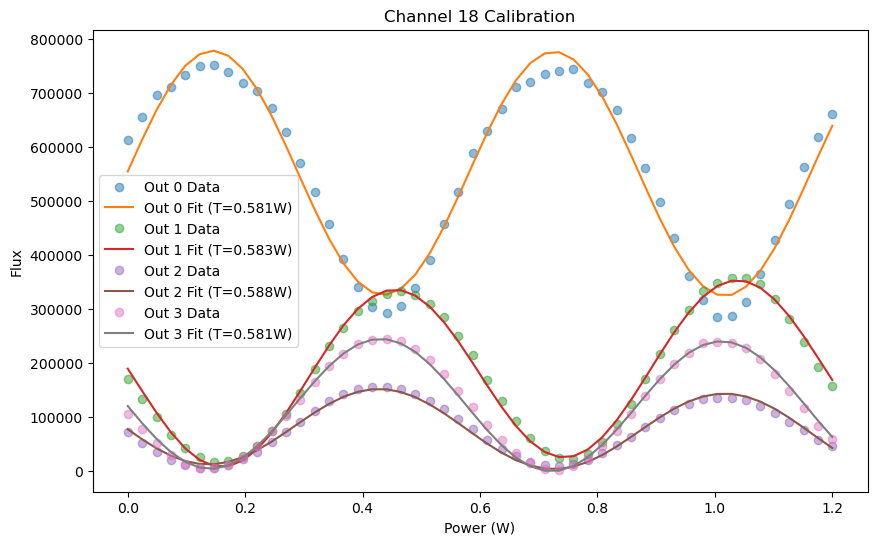

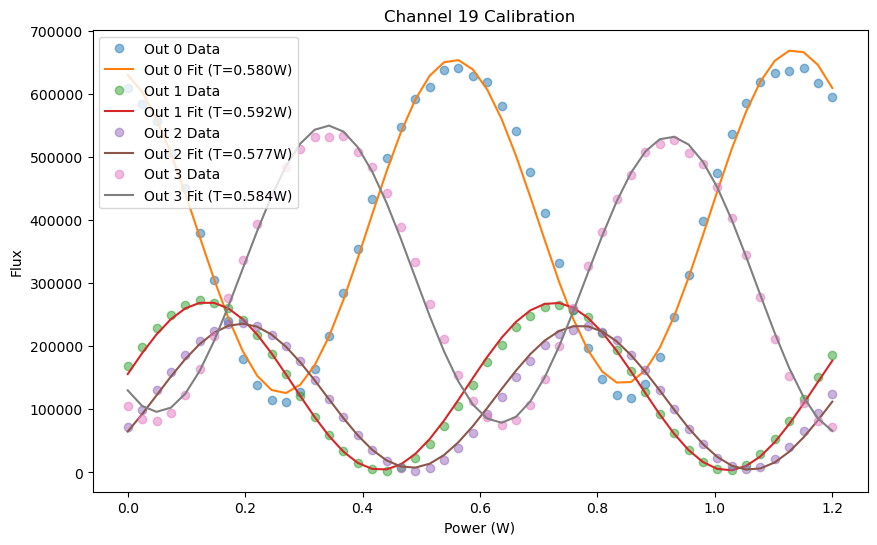

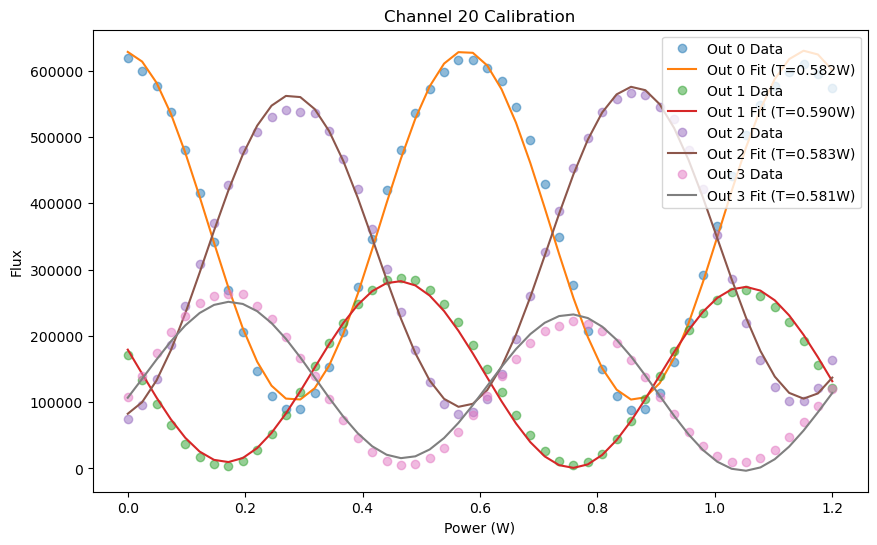

In [9]:
arch.calibrate_phase(samples=50, cred3_object=cam, crop_centers=crop_centers, crop_sizes=crop_size, plot=True)

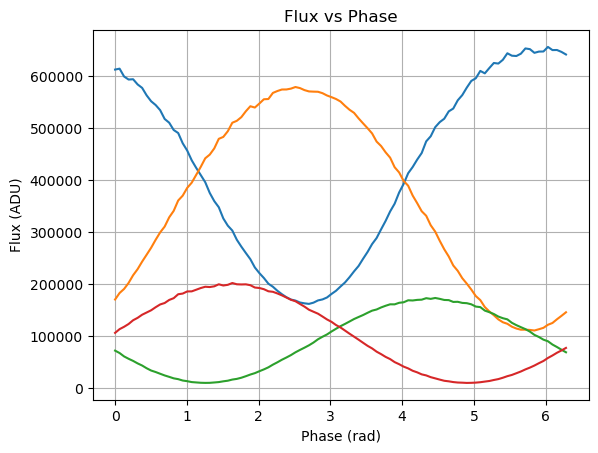

In [10]:
# Power ramp
ramp = np.linspace(0, 2*np.pi, 101) # [W]

# Data acquisition
flux = []
for shift in ramp:
    shifter.set_phase(shift)
    flux.append(cam.get_outputs(crop_centers=crop_centers, crop_sizes=crop_size))


plt.figure()
plt.plot(ramp, flux)
plt.xlabel("Phase (rad)")
plt.ylabel("Flux (ADU)")
plt.title("Flux vs Phase")
plt.grid()
plt.show()

sleep(3)
shifter.turn_off()